 # Craigslist Capstone Project - Modeling

#### The goal of this capstone is to predict market rent prices in the San Francisco Bay Area. The metros of interest are San Francisco, Peninsula, East Bay.

#### This notebook covers the scope of
Preprocessing and scaling numeric data. Splitting training and test data.

Building models:
1. Linear Regression Model
2. Stochastic Gradient Descent Model
3. Random Forest Model
4. Gradient Boosted Regressor

## Importing the libraries

In [654]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import __version__ as sklearn_version
from sklearn.linear_model import ElasticNet, LinearRegression, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression

## Load Data

In [655]:
# The data is the interim directory
df = pd.read_csv('/Users/pandabear/springboard/CapstoneTwoProject/data/interim/listing_df_EDA.csv',index_col='listing_id')
# Drop listing_city 
df.drop(['listing_city'], axis=1, inplace=True)
df

,listing_nh,listing_price,listing_sqft,listing_address,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,...,is_rent_controlled,pets_allowed,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO
listing_id,,,,,,,,,,,,,,,,,,,,,
7520103440,fremont / union city / newark,3800,1495.0,Newport Dr,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
7520905091,vallejo / benicia,2100,904.0,226 Edgemont Avenue near Edgemont Avenue,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520907681,vallejo / benicia,2200,1420.0,1509 Sacramento Street near Sacramento Street,1,1,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
7520608095,dublin / pleasanton / livermore,3935,1266.0,1552 E Gate Way,1,1,1,0,1,0,...,0,0,1,1,0,0,0,1,0,0
7520200206,dublin / pleasanton / livermore,3000,NaN,2380 Nissen Drive,1,1,1,1,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539192775,downtown / civic / van ness,6775,2540.0,"1888 Geneva Ave, 403 near Carter",0,0,0,0,0,0,...,0,0,1,1,0,1,0,1,0,0
7527460081,inner richmond,3500,1100.0,404 12th Ave #4 near Geary Blvd,0,0,1,0,0,0,...,0,1,1,0,0,0,0,0,0,0
7536441224,tenderloin,2195,NaN,725 Ellis St near Hyde,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [656]:
y = df['listing_price']
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=1,shuffle=True)

In [657]:
nh_listings_test = X_train.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
nh_listings_test.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
nh_listings_test

,listing_nh,no_bedrooms,average_price_by_nh_by_bedroom
0,SOMA / south beach,0,2599.244444
1,SOMA / south beach,1,3569.966216
2,SOMA / south beach,2,4825.238095
3,SOMA / south beach,3,6201.181818
4,SOMA / south beach,4,5247.500000
...,...,...,...
405,west portal / forest hill,5,9333.333333
406,western addition,0,2392.000000
407,western addition,1,2874.250000
408,western addition,2,4091.000000


In [658]:
nh_listings_test['average_price_by_nh_by_bedroom'].mean()

4100.1001763068925

In [659]:
y_train.shape, y_test.shape

((8215,), (3522,))

In [660]:
# Save the index to put back after scaling
X_train_index = X_train.index
X_test_index = X_test.index

## 2. Handle missing values

In [661]:
missing = pd.concat([X_train.isnull().sum(), 100 * X_train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)

,count,%
listing_sqft,2604,31.698113
transit_score,1558,18.965307
bike_score,1106,13.463177
walk_score,253,3.079732
listing_address,213,2.592818
listing_nh,0,0.000000
is_rent_controlled,0,0.000000
housing_flat,0,0.000000
housing_house,0,0.000000
housing_townhouse,0,0.000000


The missing addresses are ok to ignore since we will not be using that feature directly. The neighborhood and walk_score, transit_score, bike_scores are better representations of how desirable a property is compared to the exact address.

### Impute any missing square footage values 
Let's use the median value for the listing's number of bedroom/bathroom

In [662]:
class ImputeMissingSqft:
        
    def fit(self, X, y=None):
        # Group by bedrooms and bathrooms to find median square footage
        self.missing_sqft = X.groupby(by=['no_bedrooms','no_bathrooms']).median()['listing_sqft'].reset_index()
        self.missing_sqft.rename(columns = {'listing_sqft':'listing_sqft_median'}, inplace = True)
        mean_sqft_by_bedroom = self.missing_sqft.groupby(by='no_bedrooms').mean().reset_index()[['no_bedrooms','listing_sqft_median']]
        
        # Create a dictionary of the average sqft by bedrooms
        self.mean_sqft_by_bedroom_dict = mean_sqft_by_bedroom.set_index('no_bedrooms').to_dict()['listing_sqft_median']
        
        # Fillna for the missing values in the dictionary
        self.missing_sqft.loc[self.missing_sqft['listing_sqft_median'].isnull(),'listing_sqft_median'] = self.missing_sqft['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict)
        return self
    
    def transform(self, X):
        # Left join on bedrooms and bathrooms and use the median column if listing_sqft is null
        combined_df = X.merge(self.missing_sqft, on=['no_bedrooms','no_bathrooms'], how='left')
        
        combined_df['listing_sqft'].fillna(combined_df['listing_sqft_median'], inplace=True)
        
        # Fillna with the median listing_sqft value by bedroom only if it is a combination not seen before
        combined_df['listing_sqft'].fillna(combined_df['no_bedrooms'].map(self.mean_sqft_by_bedroom_dict), inplace=True)
        
        # Drop the extra column
        combined_df.drop(['listing_sqft_median'], axis=1, inplace=True)
        X = combined_df
        return X

### Impute any missing Walk score, Transit Score, Bike Score values
Let's use the median value for the listing's neighborhood. All transit scores range from 0 to 100

In [663]:
class ImputeMissingWalkscore:
        
    def fit(self, X, y=None):
        # Group by neighborhood to find median walks_score, transit_score, bike_score
        self.median_scores = X.groupby(by=['listing_nh']).median()[['walk_score','transit_score','bike_score']].reset_index()
        self.median_scores.rename(columns = {'walk_score':'median_walk_score','transit_score':'median_transit_score','bike_score':'median_bike_score'}, inplace = True)
        self.median_scores.fillna(0, inplace=True)
        return self
    
    def transform(self, X):
        # Left join on neighborhoods
        nh_df = X.merge(self.median_scores, on=['listing_nh'], how='left')

        # Use the mean score values if walk_score, transit_score or bike_score is null
        nh_df['walk_score'].fillna(nh_df['median_walk_score'],inplace=True)
        nh_df['transit_score'].fillna(nh_df['median_transit_score'],inplace=True)
        nh_df['bike_score'].fillna(nh_df['median_bike_score'],inplace=True)

        # In case there is a new neighborhood that doesn't have a mean walk/bike/transit score, use the mean of median_scores to fill null values
        nh_df['walk_score'].fillna(self.median_scores['median_walk_score'].mean(),inplace=True)
        nh_df['transit_score'].fillna(self.median_scores['median_transit_score'].mean(),inplace=True)
        nh_df['bike_score'].fillna(self.median_scores['median_bike_score'].mean(),inplace=True)
        
        # Drop unused columns
        nh_df.drop(['median_walk_score','median_transit_score','median_bike_score','listing_address'], axis=1,inplace=True)

        X = nh_df
        return X

## 4. Remove outliers
### For studio listings
During EDA, it became clear that studio listing prices had a very long tail - possibly because some listings were misclassified as studios when they should have been 1 or 2 bedroom apartments. 
To remove these outliers, cap the prices of studios to the 99th percentile

In [664]:
class RemoveOutliersStudios:
    def fit(self, X, y=None):
        # Cap the top 1% percentile of all listing_price for studios
        self.upper_lim = X[X['no_bedrooms'] == 0]['listing_price'].quantile(q = 0.99)
        return self
    
    def transform(self, X):
        X.loc[(X['listing_sqft'] > self.upper_lim) & (X['no_bedrooms'] == 0),'listing_price'] = self.upper_lim
        # Drop listing_price column
        X.drop(['listing_price'], axis=1, inplace=True)
        
        return X

### For listing square footage grouped by number of bedrooms

In [665]:
class CapOutliersSquareFootageByBedroom:
    def fit(self, X, y=None):
        grouped_bed_median = X.groupby(by=['no_bedrooms']).median()[['listing_sqft']].reset_index()
        grouped_bed_std = X.groupby(by=['no_bedrooms']).std()[['listing_sqft']].reset_index()
        self.sqft = pd.merge(grouped_bed_median, grouped_bed_std, on = "no_bedrooms", how = "inner")
        self.sqft.rename(columns = {'listing_sqft_x':'median_sqft', 'listing_sqft_y':'std_sqft'}, inplace = True)
        
        # Calculate the upper limit
        self.sqft['upper_lim'] = self.sqft.apply(lambda row: row['median_sqft'] + row['std_sqft'] * 3, axis = 1).astype(int)
        return self
    
    def transform(self, X):
        X = X.merge(self.sqft[['no_bedrooms','upper_lim']], on=['no_bedrooms'], how='left')
        X['listing_sqft'] = np.where((X['listing_sqft'] > X['upper_lim']), X['upper_lim'], X['listing_sqft'])
        # Drop upper_lim column
        X.drop(['upper_lim'], axis=1, inplace=True)
        return X

## 3. Feature engineering for categorical variables
The remaining categorical features are neighborhood and city. Since a city includes multiple neighborhoods, we can use the neighborhood feature in lieu of the city feature entirely. 
The most common size of rental units are 1 bedroom/1 bathroom ones. There are too many neighborhoods to one hot encode so instead impute using the mean price per 1 bedroom/1 bathroom listing for that neighborhood or city. 

Let's create or own Estimator to replace the categorical feature neighborhoods to the average listing price of 1 bedroom/1 bathroom places for each neighborhood. 

In [666]:
# List all the unique neighborhoods in the entire dataset
unique_nh = df.listing_nh.unique()
print(f'There are {len(unique_nh)} unique neighborhoods in the dataframe')

There are 82 unique neighborhoods in the dataframe


In [667]:
class NHAveragePrice:

# # Option 1: Group by neighborhood and number of bedrooms
#     def fit(self, X, y=None):
#         # Group by neighborhood and number of bedrooms
#         self.nh_listings = X.groupby(['listing_nh','no_bedrooms'])['listing_price'].mean().reset_index()
#         self.nh_listings.rename(columns = {'listing_price':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         return self
    
#     def transform(self, X):
#         combined_df = X.merge(self.nh_listings, on=['listing_nh','no_bedrooms'], how='left')
#         combined_df.rename(columns = {'listing_price_y':'average_price_by_nh_by_bedroom'}, inplace = True)
        
#         # If there is a combination of neighborhood and bedroom number not seen in the training set, impute the median price
#         combined_df['average_price_by_nh_by_bedroom'].fillna(self.nh_listings['average_price_by_nh_by_bedroom'].mean(), inplace=True)
#         X = combined_df
#         return X
    
# Option 2: Group by neighborhood and square footage

    def fit(self, X, y=None):
        # Group by neighborhood and square footage
        X['price_per_sqft'] = X['listing_price']/X['listing_sqft']
        self.nh_price = X.groupby(['listing_nh'])['price_per_sqft'].mean().reset_index()
        X.drop(['price_per_sqft'], axis=1, inplace=True)

        return self
    
    def transform(self, X):
        avg_nh_df = X.merge(self.nh_price, on=['listing_nh'], how='left')
        
        # If there is a neighborhood not seen in the training set, impute the median value for all neighborhoods
        avg_nh_df['price_per_sqft'].fillna(self.nh_price['price_per_sqft'].median(), inplace=True)
        avg_nh_df['price_estimate_sqft_nh'] = avg_nh_df['price_per_sqft'] * avg_nh_df['listing_sqft']
        avg_nh_df.drop(['listing_nh'], axis=1,inplace=True)
        X = avg_nh_df
        return X


## 6. Standardize numeric features

In [669]:
# class DataframeMinMaxScaler:
#     def __init__(self, columns):
#         self.columns = columns
#         self.scaler = MinMaxScaler()
        
#     def fit(self, X, y=None):
#         self.scaler.fit(X[self.columns])
#         return self
    
#     def transform(self, X):
#         X[self.columns] = self.scaler.transform(X[self.columns])
#         return X
    
class DataframeStandardScaler:
    def __init__(self, columns):
        self.columns = columns
        self.scaler = StandardScaler()
        
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns])
        return self
    
    def transform(self, X):
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

In [670]:
nh = NHAveragePrice()
sqft1 = ImputeMissingSqft()
walk = ImputeMissingWalkscore()
outliers = RemoveOutliersStudios()
sqft2 = CapOutliersSquareFootageByBedroom()
scale = DataframeStandardScaler(['listing_sqft','walk_score','transit_score','bike_score','no_bedrooms','no_bathrooms','price_per_sqft','price_estimate_sqft_nh'])

p = Pipeline([
    ('impute_missing_sqft', sqft1),
    ('impute_missing_walkscore', walk),
    ('nh_average_price', nh),
    ('remove_outliers_studios', outliers),
    ('Cap_Outliers_Square_Footage_By_Bedroom', sqft2),
    ('standard_scaler', scale)
])

X_train = p.fit_transform(X_train)
X_test = p.transform(X_test)

In [671]:
# Assign index back
X_train.index = X_train_index
X_test.index = X_test_index
X_train

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,has_amenities,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh
listing_id,,,,,,,,,,,,,,,,,,,,,
7536389574,1990.0,1,1,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,2.839581,5650.765266
7531498619,680.0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,4.581347,3115.316092
7526046874,650.0,0,0,1,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,3.233123,2101.530267
7521853206,870.5,1,1,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,4.283888,3729.124310
7546370592,968.0,1,1,0,1,0,1,0,1,0,...,1,1,0,1,0,1,0,0,2.891195,2798.676772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7519744420,600.0,0,0,1,0,0,1,1,0,0,...,1,0,0,0,1,1,0,0,3.688346,2213.007336
7539165126,1150.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,4.247341,4884.442394
7521362278,870.5,0,0,0,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,4.529405,3942.846862


In [672]:
print(f'There are {X_train.isnull().sum().sum()} missing rows in X_train')
print(f'There are {X_test.isnull().sum().sum()} missing rows in X_test')

There are 0 missing rows in X_train
There are 0 missing rows in X_test


In [673]:
X_test.price_per_sqft.describe()

count    3522.000000
mean        3.600330
std         0.687975
min         1.475931
25%         3.079484
50%         3.592457
75%         4.169542
max         5.098509
Name: price_per_sqft, dtype: float64

In [681]:
# Create another version of df that is unscaled but transformed for graphing purposes only

df_nonscaled = pd.concat([X_train, X_test])
listing_prices = pd.concat([y_train, y_test])
df_nonscaled = pd.concat([df_nonscaled, listing_prices], axis=1, join='inner')
df_nonscaled

,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,hasEVCharging,laundry_in_bldg,laundry_in_unit,laundry_has_hookup,...,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh,listing_price
listing_id,,,,,,,,,,,,,,,,,,,,,
7536389574,1990.0,1,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,2.839581,5650.765266,4200
7531498619,680.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.581347,3115.316092,2650
7526046874,650.0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,3.233123,2101.530267,1850
7521853206,870.5,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4.283888,3729.124310,3250
7546370592,968.0,1,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,0,2.891195,2798.676772,3711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541815611,890.0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,3.595400,3199.905972,2675
7545109902,870.5,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,3.348622,2914.975569,2800
7531988589,1309.0,1,1,1,0,1,0,0,1,0,...,1,0,1,0,1,0,0,2.939699,3848.066333,3614


## 1. Linear Regression

In [398]:
regr = LinearRegression()
regr.fit(X_train, y_train)
print(f'Coefficient of determination of training set: {regr.score(X_train, y_train):.2f}')
print(f'Coefficient of determination of test set: {regr.score(X_test, y_test):.2f}')

Coefficient of determination of training set: 0.73
Coefficient of determination of test set: 0.73


In [399]:
param_grid = { 
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
}

cv = GridSearchCV(estimator=ElasticNet(max_iter=100000, warm_start=True, tol=1e-4), param_grid=param_grid, cv=5, refit=True)
cv.fit(X_train, y_train)

# Apply RF to the training data:
regr = cv.best_estimator_

print(f'Cross Validation best parameters: {cv.best_params_}')
print(f'Coefficient of determination of training set: {regr.score(X_train, y_train):.2f}')
print(f'Coefficient of determination of test set: {regr.score(X_test, y_test):.2f}')

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.969e+06, tolerance: 1.531e+06
  model = cd_fast.enet_coordinate_descent(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.537e+06, tolerance: 1.517e+06
  model = cd_fast.enet_coordinate_descent(
/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Cross Validation best parameters: {'alpha': 0.001}
Coefficient of determination of training set: 0.73
Coefficient of determination of test set: 0.73


The coefficient of determination for the test set is close to the training set, which suggests the model has low variance.

In [400]:
# Predict price from X_test
y_pred_lr = regr.predict(X_test)

In [401]:
#scores = cross_val_score(regr, X_test, y_test, cv=5)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [402]:
print(f'MAE test: {mean_absolute_error(y_test, y_pred_lr):.2f}')
print(f'RMSE test: {mean_squared_error(y_test, y_pred_lr, squared=False):.2f}')
print(f'R2 score: {r2_score(y_test, y_pred_lr):.2f}')

MAE test: 518.25
RMSE test: 780.09
R2 score: 0.73


Interpretation of these metrics: On average, the MAE is 533 dollars away from the predicted value. The RMSE value is high and reflective of the right-skewness of the target variable.

## 2. Stochastic Gradient Descent

In [580]:
sgd = SGDRegressor(penalty='elasticnet')
sgd.fit(X_train, y_train)
y_pred_sgd = sgd.predict(X_test)

Text(0.5, 1.0, 'Residual Density for Linear Regression in dollar amount')

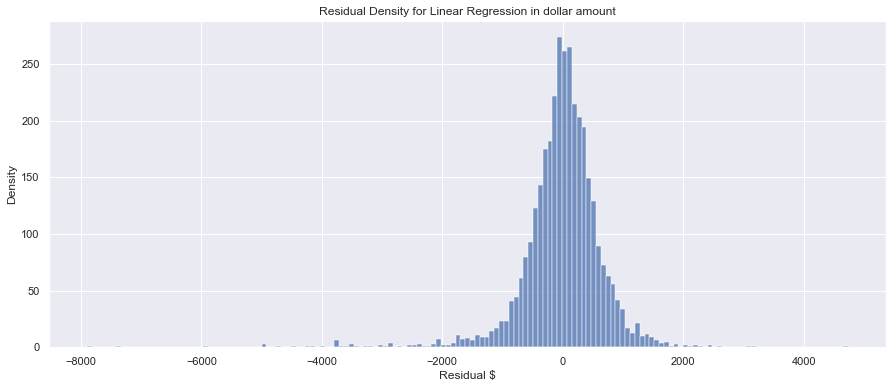

In [581]:
residuals_as_prices = y_pred_sgd - y_test
# Plot test set with missing sqft that was imputed
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(residuals_as_prices)
plt.ylabel('Density')
plt.xlabel('Residual $')
plt.title('Residual Density for Linear Regression in dollar amount')

In [582]:
print(f'MAE test: {mean_absolute_error(y_test, y_pred_sgd):.2f}')
print(f'RMSE test: {mean_squared_error(y_test, y_pred_sgd, squared=False):.2f}')
print(f'R2 score: {r2_score(y_test, y_pred_sgd):.2f}')

MAE test: 446.94
RMSE test: 699.08
R2 score: 0.78


The Stochastic Gradient Descent model works much faster than Linear regression, and has similar results. 

There seems to be a long left tail where the model is predicting higher prices for a listing than the actual price.
Let's look into the proportions of residual distribution. Define a low residual as one where the model has closely predicted the listing price. A medium residual to be an ok prediction but off by a few hundred, and a high residual as a predicted value that wouldn't help inform the user. 

In [583]:
# Take a closer look at why the data with high residuals
X_test_size = X_test.shape[0]

low_residual = 100
med_residual = 500
high_residual = 1000

# Also useful to compare percentages of the listing price
low_residual_percent = 0.15

# Residual = predicted - actual list price
residual = pd.DataFrame(y_pred_sgd - y_test)

residual.rename(columns = {'listing_price':'price_residual'}, inplace = True)


In [584]:
pred_sgd = pd.DataFrame(y_pred_sgd, columns = ['predicted_price'])
pred_sgd.sort_values(by='predicted_price')

,predicted_price
1227,835.256070
2200,999.836660
484,1077.614165
801,1090.806393
732,1100.049019
...,...
500,9794.717791
345,9816.090042
1996,10439.381466
574,10906.627979


In [586]:
residual['listing_price'] = y_test
residual['residual_percent'] = residual['price_residual']/residual['listing_price']
residual['residual_category'] = np.where(np.abs(residual['residual_percent'])<low_residual_percent, 'Within_15_percent', 'More_than_15_percent')
# Drop duplicated index
residual = residual.groupby(residual.index).first()
residual

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7495966009,-1742.808355,4999,-0.348631,More_than_15_percent
7496160361,241.079439,2315,0.104138,Within_15_percent
7496528615,-310.688315,2195,-0.141544,Within_15_percent
7496541615,276.292835,2195,0.125874,Within_15_percent
7496841090,-257.863570,4495,-0.057367,Within_15_percent
...,...,...,...,...
7546415237,-1227.960050,4251,-0.288864,More_than_15_percent
7546424014,-727.079440,3200,-0.227212,More_than_15_percent
7546436808,-303.334615,2240,-0.135417,Within_15_percent


Text(0.5, 1.0, 'Residual Density as a proportion of listing price for Linear Regression')

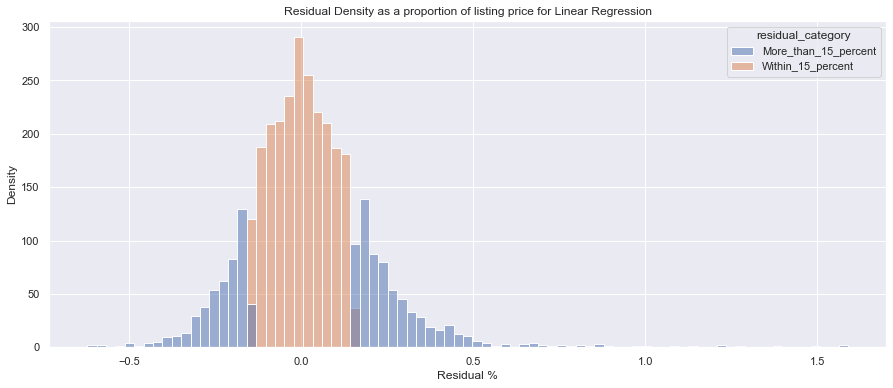

In [587]:
# Plot the distribution of residuals as a percentage
sns.set(rc={"figure.figsize":(15, 6)})
s = sns.histplot(data = residual, x='residual_percent', hue='residual_category')
plt.ylabel('Density')
plt.xlabel('Residual %')
plt.title('Residual Density as a proportion of listing price for Linear Regression')

The long right tail in the residual plot suggets the model is predicting higher values than what is actually listed as the rental price. This could be because the model is identifying good deals where the unit is being rented for a price below market value. This information could be very informative to renters who are in the rental market.

In [588]:
residual[residual['residual_percent'] > 1]

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7511760382,2308.229890,1550,1.489181,More_than_15_percent
7513793874,1453.446823,1284,1.131968,More_than_15_percent
7519114049,3188.896604,2498,1.276580,More_than_15_percent
7519951050,1737.192034,1595,1.089149,More_than_15_percent
7520200206,4734.980956,3000,1.578327,More_than_15_percent
7534446207,1825.511573,1500,1.217008,More_than_15_percent
7540351714,1740.858597,1095,1.589825,More_than_15_percent
7542696603,2018.556103,1650,1.223367,More_than_15_percent
7545575566,2205.462182,1600,1.378414,More_than_15_percent


In [589]:
# Look at the high_residual rows
index_of_interest_high = residual[(residual['price_residual'] > high_residual) | (residual['price_residual'] < -high_residual)].index
print(f'Results for X_test with missing square footage values imputed:')
print(f'There are {len(index_of_interest_high)} rows that have residuals greater than {high_residual} between actual and predicted price, which is {(len(index_of_interest_high)/X_test_size)*100:.1f}% of all rows')

# Look at the med_residual rows
index_of_interest_med = residual[(residual['price_residual'] < med_residual) & (residual['price_residual'] > -med_residual)].index
print(f'There are {len(index_of_interest_med)} rows that have residuals less than {med_residual} between actual and predicted price, which is {(len(index_of_interest_med)/X_test_size)*100:.1f}% of all rows')

# Look at the low_residual rows
index_of_interest_low = residual[(residual['price_residual'] > -low_residual) & (residual['price_residual'] < low_residual)].index
print(f'There are {len(index_of_interest_low)} rows that have residuals less than {low_residual} between actual and predicted price, which is {(len(index_of_interest_low)/X_test_size)*100:.1f}% of all rows')


Results for X_test with missing square footage values imputed:
There are 302 rows that have residuals greater than 1000 between actual and predicted price, which is 8.6% of all rows
There are 2464 rows that have residuals less than 500 between actual and predicted price, which is 70.0% of all rows
There are 676 rows that have residuals less than 100 between actual and predicted price, which is 19.2% of all rows


In [590]:
# Calculate the same comparison for predicted price within % of actual price
# Within 20%
index_of_interest_20 = residual[(residual['residual_percent'] > 0.2) | (residual['residual_percent'] < -0.2)].index
print(f'There are {X_test_size - len(index_of_interest_20)} rows that have residuals less than 20% between actual and predicted price, which is {((X_test_size - len(index_of_interest_20))/X_test_size)*100:.1f}% of all rows in the test set')

# Within 10%
index_of_interest_10 = residual[(residual['residual_percent'] > 0.1) | (residual['residual_percent'] < -0.1)].index
print(f'There are {X_test_size - len(index_of_interest_10)} rows that have residuals less than 10% between actual and predicted price, which is {((X_test_size - len(index_of_interest_10))/X_test_size)*100:.1f}% of all rows in the test set')



There are 2805 rows that have residuals less than 20% between actual and predicted price, which is 79.6% of all rows in the test set
There are 1697 rows that have residuals less than 10% between actual and predicted price, which is 48.2% of all rows in the test set


In [683]:
# Get index of rows of interest, where residual is greater than a residual percentage of 15%
listing_ids_residuals = residual[residual['residual_category'] == 'More_than_15_percent']
listing_ids_residuals

,price_residual,listing_price,residual_percent,residual_category
listing_id,,,,
7495966009,-1742.808355,4999,-0.348631,More_than_15_percent
7497264991,430.668619,2300,0.187247,More_than_15_percent
7497314691,510.266454,2450,0.208272,More_than_15_percent
7497958389,-575.441782,3100,-0.185626,More_than_15_percent
7498219299,-1778.718220,6995,-0.254284,More_than_15_percent
...,...,...,...,...
7546394059,664.407862,2895,0.229502,More_than_15_percent
7546405517,514.644016,1000,0.514644,More_than_15_percent
7546415237,-1227.960050,4251,-0.288864,More_than_15_percent


In [684]:
# Look at residuals as a percentage of listing price
residuals_df = pd.merge(listing_ids_residuals, df_nonscaled, on = 'listing_id', how = 'left')

residuals_df['residual_percent'] = residuals_df['residual_percent']*100

# Only look at rows that have listing_sqft i.e. it was not imputed
residuals_df = residuals_df[residuals_df.listing_sqft.notnull()]


In [685]:
residuals_df.head()

,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,premium_finishes,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh,listing_price_y
listing_id,,,,,,,,,,,,,,,,,,,,,
7495966009,-1742.808355,4999,-34.863140,More_than_15_percent,927.0,0,0,0,0,0,...,0,0,0,0,0,0,0,4.283888,3971.163969,4999
7497264991,430.668619,2300,18.724723,More_than_15_percent,870.5,1,0,0,0,0,...,0,0,0,0,0,0,0,3.217752,2801.053062,2300
7497314691,510.266454,2450,20.827202,More_than_15_percent,1382.0,0,0,0,0,0,...,0,0,0,0,1,0,0,2.628627,3632.762539,2450
7497958389,-575.441782,3100,-18.562638,More_than_15_percent,680.0,0,0,1,0,0,...,1,0,0,0,1,0,0,3.765769,2560.723046,3100
7498219299,-1778.718220,6995,-25.428423,More_than_15_percent,1600.0,0,0,1,0,0,...,0,0,0,0,0,0,0,3.649254,5838.806802,6995


[Text(0.5, 1.0, 'Price residual by number of bedrooms')]

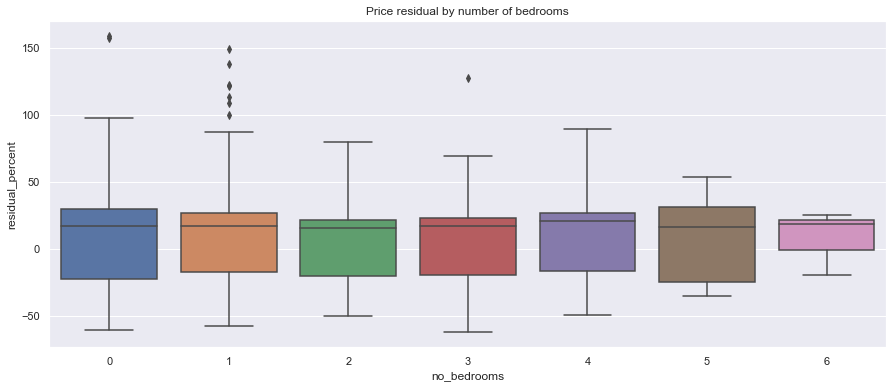

In [686]:
# Plot the residuals on a boxplot, grouped by number of bedrooms
sns.boxplot(data=residuals_df, y ='residual_percent',x='no_bedrooms').set(title='Price residual by number of bedrooms')


The prediction accuracy is the worst for 1 bedroom places. This could be because they are the most common listing size. Another way to segment the listings would be by square footage. The average square footage sizes are:
* Studio apartments: 400-600 sqft
* 1 bedroom apartments: 700-800 sqft
* 2 bedroom apartments: 900- 1200 sqft
* 3+ bedroom apartments: 1300 sqft+

[Text(0.5, 1.0, 'Price residual by listing square footage')]

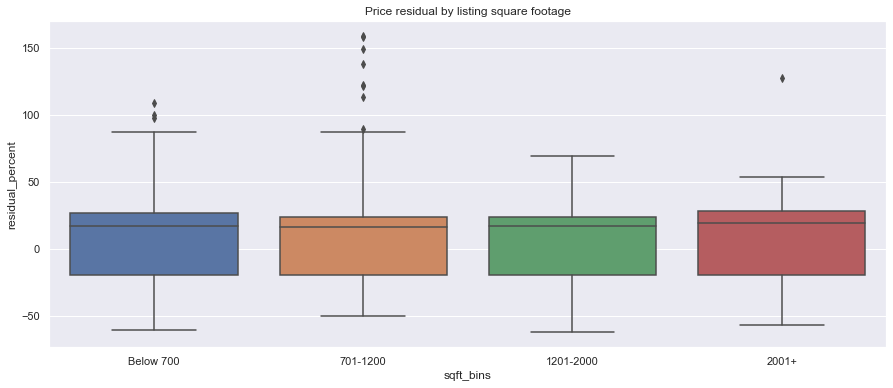

In [687]:
# Plot the residuals on a boxplot, grouped by bins of square footage values

residuals_df['sqft_bins'] = pd.cut(residuals_df['listing_sqft'], bins=[0, 700, 1200, 2000, float('Inf')], labels=['Below 700', '701-1200','1201-2000','2001+'])
sns.boxplot(data=residuals_df, y ='residual_percent',x='sqft_bins').set(title='Price residual by listing square footage')


This plot suggests the high residuals are concentrated in the less than 1200 square foot range, which is consistent with 1 bedroom apartments being the most common sized places for rent. 

In [688]:
# Look at residuals greater than 50%
residuals_50 = residuals_df[(residuals_df['residual_percent'] > 0.5) | (residuals_df['residual_percent'] < -0.5)]
print(f'There are {residuals_50.shape[0]} rows that had residuals greater than 50%')
residuals_50.head()

There are 1177 rows that had residuals greater than 50%


,price_residual,listing_price_x,residual_percent,residual_category,listing_sqft,animals_cats,animals_dogs,smoking,wheelchair accessible,has_AC,...,ensuite_bath,has_balcony,has_backyard,has_view,multi-level,is_an_SRO,price_per_sqft,price_estimate_sqft_nh,listing_price_y,sqft_bins
listing_id,,,,,,,,,,,,,,,,,,,,,
7495966009,-1742.808355,4999,-34.863140,More_than_15_percent,927.0,0,0,0,0,0,...,0,0,0,0,0,0,4.283888,3971.163969,4999,701-1200
7497264991,430.668619,2300,18.724723,More_than_15_percent,870.5,1,0,0,0,0,...,0,0,0,0,0,0,3.217752,2801.053062,2300,701-1200
7497314691,510.266454,2450,20.827202,More_than_15_percent,1382.0,0,0,0,0,0,...,0,0,0,1,0,0,2.628627,3632.762539,2450,1201-2000
7497958389,-575.441782,3100,-18.562638,More_than_15_percent,680.0,0,0,1,0,0,...,0,0,0,1,0,0,3.765769,2560.723046,3100,Below 700
7498219299,-1778.718220,6995,-25.428423,More_than_15_percent,1600.0,0,0,1,0,0,...,0,0,0,0,0,0,3.649254,5838.806802,6995,1201-2000


In [689]:
# residuals_50[residuals_50.index.duplicated(keep='first')]

[Text(0.5, 1.0, 'Distribution of residuals greater than 50% by square footage')]

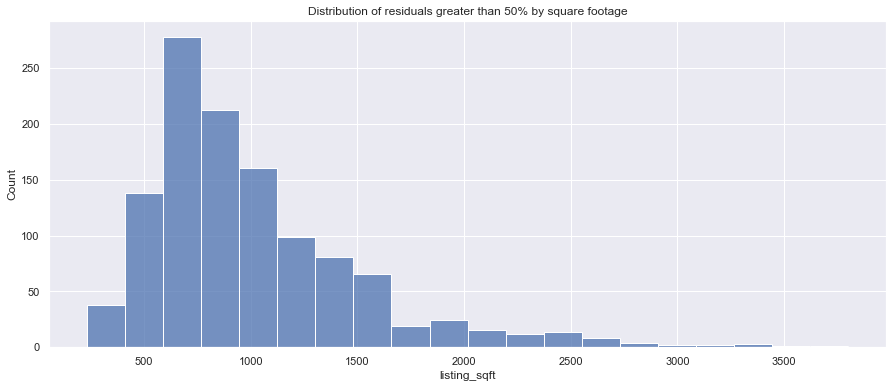

In [690]:
# Plot the price residual distribution of square footage as a histogram
sns.histplot(data=residuals_50, x="listing_sqft", bins=20).set(title='Distribution of residuals greater than 50% by square footage')


This looks like a similar distribution to the plot from EDA for the square footage feature, and there is no obvious cluster of listings that differs from the population distribution. 

[Text(0.5, 1.0, 'Distribution of residuals over 50%')]

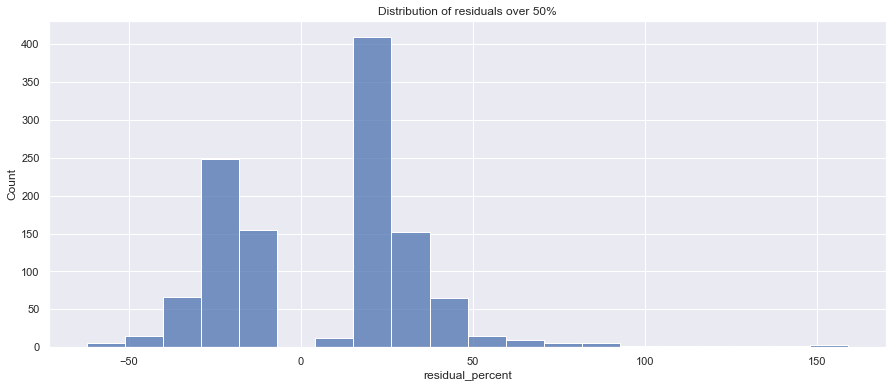

In [691]:
# Plot the distribution of residuals over 50%
# residual_distribution = residuals_50.residual_percent.hist(figsize=(10,5), bins=20)
# plt.title("Distribution of residuals over 50%")

sns.histplot(data=residuals_50, x="residual_percent", bins=20).set(title='Distribution of residuals over 50%')


There are more residuals on the right hand side, which suggest the listings are below the predicted market price.

## 3. Random Forest Regressor

In [600]:
param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6]
}

CV_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv = 5, refit = True)
CV_rf.fit(X_train, y_train)

# Apply RF to the training data:
rf = CV_rf.best_estimator_

print(f'Cross Validation best parameters: {CV_rf.best_params_}')

Cross Validation best parameters: {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}


In [601]:
# Predict using the model:
y_pred = rf.predict(X_test)

# Accuracy score
print(f'Accuracy for Random Forest on CV data: {rf.score(X_test,y_test):.2f}')

Accuracy for Random Forest on CV data: 0.77


## 4. Gradient Boosting Regressor

In [602]:
n_features = X_train.shape[1]
gb = GradientBoostingRegressor(random_state = 0)

distributions = dict(learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5], 
                    max_depth = [1,2,3,4,5],
                     max_features = np.arange(1, n_features, 1),
                    n_estimators = [20,40,60,80,100,125,150])

gb_randomsearch = RandomizedSearchCV(gb, distributions, random_state=0)
search = gb_randomsearch.fit(X_train, y_train)

print(f'Random Search best parameters: {search.best_params_}')

Random Search best parameters: {'n_estimators': 60, 'max_features': 22, 'max_depth': 5, 'learning_rate': 0.1}


In [603]:
gb = GradientBoostingRegressor(n_estimators=150, learning_rate = 0.75, max_depth = 2, max_features = 2, random_state = 0)

gb.fit(X_train, y_train)

gb.predict(X_test)

gb_score = gb.score(X_test, y_test)
print(f'Gradient Boosting score: {gb_score}')

Gradient Boosting score: 0.7514110624021478


Text(0.5, 1.0, 'Residual Density')

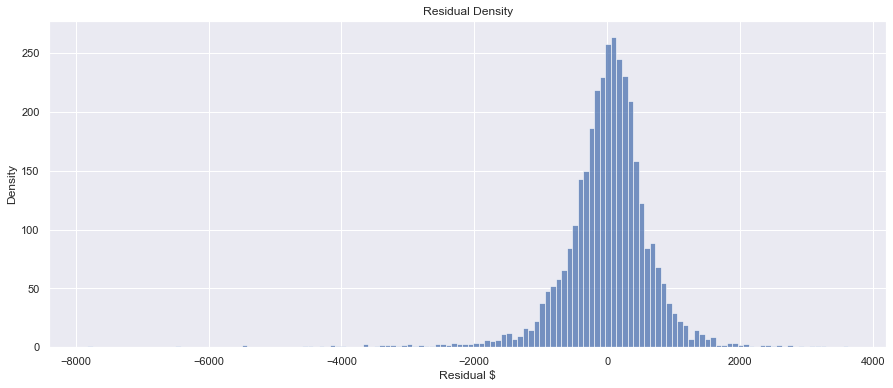

In [604]:
sns.set(rc={"figure.figsize":(15, 6)})
g = sns.histplot(y_pred-y_test)
plt.ylabel('Density')
plt.xlabel('Residual $')
plt.title('Residual Density')

# Feature Exploration

Look at the linear regression model and the feature coefficients to see if they make sense

In [ ]:
coefs = pd.DataFrame(
   regr.coef_,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature Coefficients')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [ ]:
regr.coef_

In [ ]:
X_train.head(8)

In [ ]:
y_train.head(8)

In [ ]:
y_test

In [ ]:
X_test.index.get_loc(7521959344)
y_test.loc[7521959344]

In [ ]:
def explain(model, X, y, listing_id):
    row = X.loc[listing_id]
    idx = X.index.get_loc(listing_id)
#     y_actual = y[idx]
    y_actual = y.loc[listing_id]
    y_pred = model.predict(X)[idx]
    contributions = [
        (feature, row[i] * model.coef_[i])
        for i, feature in enumerate(X.columns)
    ]
    print(f'y_actual : {y_actual}')
    print()
    print(f'y_pred : {y_pred}')
    print(f'intercept : {model.intercept_}')
    for feature, contribution in sorted(contributions, reverse=True, key=lambda c: abs(c[1])):
        if (abs(contribution)) > 0.1:
            print(f'{feature} : {contribution:.2f}')

Look at a specific listing to see the price contributions of each feature. In this case, the predicted price is lower than the actual listing price

In [ ]:
explain(sgd, X_train, y_train, 7521959344)

In [ ]:
X_test.loc[7521959344]

In [ ]:
X_test.head()

In [ ]:
explain(sgd, X_test, y_test, 7521959344)

In [ ]:
regr.coef_

In [ ]:
regr.feature_names_in_

In [ ]:
#df_nonscaled.loc[7501999676]

In [ ]:
feature_coef_dict = {}

def get_feature_raw_coefficients(feature_transformer, model):
    features = model.feature_names_in_
    X_base = pd.DataFrame.from_records([[0]*len(features)], columns=features)
    y_base = model.predict(feature_transformer.transform(X_base))
    for i, feature in enumerate(features):
        feature_values = [[0]*len(features)]
        feature_values[0][i] = 1
        X = pd.DataFrame.from_records(feature_values, columns=features)
        y = model.predict(feature_transformer.transform(X))
#         print(f'{feature} : {y[0] - y_base[0]}')
        feature_coef_dict[feature] = y[0] - y_base[0]
    return feature_coef_dict
    
get_feature_raw_coefficients(scale, regr)

### Look at the average contribution to the overall rental price of features of interest 
Features of interest:
* Allows pets
* Is wheelchair accessible
* Allows smoking
* Has Air Conditioning
* Has EV charging
* Has laundry in-unit
* Has offstreet parking
* Has Valet parking
* Has a high walk score/transit score (define high as ?, no car dependency)
* Has amenities
* Has premium finishes
* Has a backyard
* Has a view

In [706]:
# Convert dictionary to DataFrame
model_coef = pd.DataFrame(list(feature_coef_dict.items()))
model_coef.columns = ['feature','model_coef']
model_coef.set_index('feature', inplace=True)

model_coef

,model_coef
feature,
listing_sqft,1.419919
animals_cats,-79.430112
animals_dogs,159.638846
smoking,-4.244198
wheelchair accessible,145.058456
has_AC,-61.667075
hasEVCharging,90.742820
laundry_in_bldg,91.889574
laundry_in_unit,461.590550


In [707]:
# Calculate metrics of parking that is a designated parking location but not street parking
has_offstreet_parking = ['parking_carport', 'parking_attached_garage','parking_detached_garage', 'parking_offstreet']

# How often do the features appear in X_train?
X_train_len = X_train.shape[0]
parking_coef = 0

for parking_option in has_offstreet_parking:
    parking_coef += (model_coef.loc[parking_option] * X_train[parking_option].sum())/X_train_len


model_coef.loc['non_street_parking'] = parking_coef

features_of_interest = ['pets_allowed','smoking','wheelchair accessible','has_AC','hasEVCharging',
       'laundry_in_unit', 'parking_valet', 'non_street_parking', 'has_amenities', 'premium_finishes', 'has_backyard', 'has_view']

model_coef = model_coef.loc[features_of_interest]
model_coef

,model_coef
feature,
pets_allowed,-159.648341
smoking,-4.244198
wheelchair accessible,145.058456
has_AC,-61.667075
hasEVCharging,90.742820
laundry_in_unit,461.590550
parking_valet,1230.267113
non_street_parking,6.099942
has_amenities,88.765603


Text(0.5, 1.0, '$ Price change per 1 unit change in features')

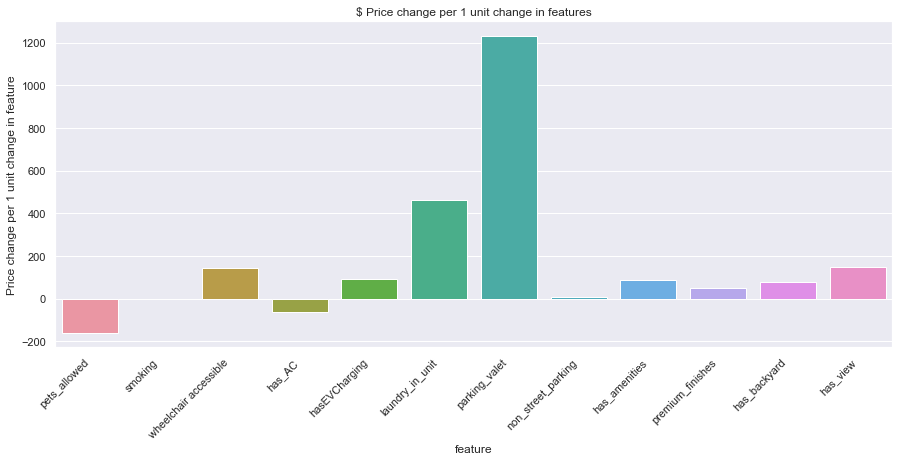

In [708]:
# Plot the model coefficients for each feature
chart = sns.barplot(data=model_coef.reset_index(), x="feature", y="model_coef")
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_ylabel('Price change per 1 unit change in feature')
chart.set_title('$ Price change per 1 unit change in features')